NOTEBOOK OVERVIEW:

LOAD DATA: This notebook gets the BillSum dataset from HuggingFace, splits the pre-specified "training" set into training validation sets, and maintains BillSum's 3000+ row "test" set as an unseen holdout set.

EDA: We do a quick EDA to show the average length of inputs, which becomes important for understanding model performance later in the project.

BASIC PRE-PROCESSING: Finally, we get the data into the right format for training by creating pairs of Orig/Target. The data can then be loaded from drive into other notebooks for training and inference / text generation.

In [ ]:
# mount to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install transformers
!pip install sentencepiece

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from transformers import AutoTokenizer  , TFAutoModel
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

In [ ]:
import pandas as pd
from datasets import load_dataset
from datasets import get_dataset_split_names
from datasets import DatasetDict

print(get_dataset_split_names('billsum'))
# billsum will be the train + valid set (split it below after loading)
# billsum_test is holdout unseen test set
billsum = load_dataset("billsum",split = 'train')
billsum_test = load_dataset("billsum",split = 'test')

billsum = billsum.train_test_split(test_size=0.2) # split the train data in 2 for train/valid

In [ ]:
billsum.keys()

dict_keys(['train', 'test'])

In [ ]:
billsum_train = billsum['train']
billsum_valid = billsum['test'] # the "test" data from the split train data becomes the valid set

In [ ]:
print(billsum_train.shape)
print(billsum_valid.shape)
print(billsum_test.shape)
print(billsum_train.column_names)

(15159, 3)
(3790, 3)
(3269, 3)
['text', 'summary', 'title']


(5000.0, 20000.0)

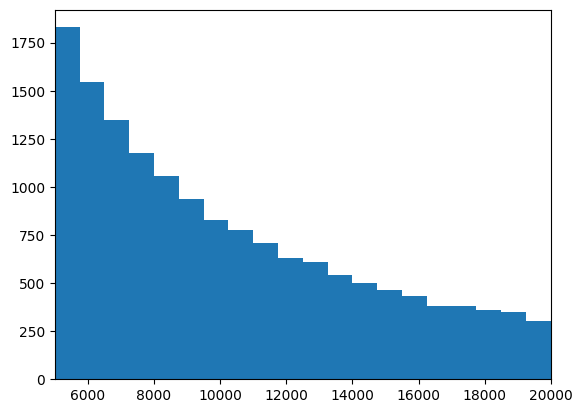

In [ ]:
# add some eda here - what is the average length of the orig text?
import matplotlib.pyplot as plt

text_lengths_in_chars = [] # training set
text_lengths_in_words = [] # training set
for text in billsum_train['text']:
  text_lengths_in_chars.append(len(text))
  split_text = text.split()
  text_lengths_in_words.append(len(split_text))
plt.hist(text_lengths_in_chars, bins = 20)
plt.xlim(xmin=5000, xmax = 20000)
# bills with 5,000 to 20,000 characters are included by authors of dataset

(array([  23.,  177., 2171., 2821., 2244., 1768., 1418., 1225., 1050.,
         855.,  672.,  449.,  225.,   52.,    9.]),
 array([ 194.        ,  384.73333333,  575.46666667,  766.2       ,
         956.93333333, 1147.66666667, 1338.4       , 1529.13333333,
        1719.86666667, 1910.6       , 2101.33333333, 2292.06666667,
        2482.8       , 2673.53333333, 2864.26666667, 3055.        ]),
 <BarContainer object of 15 artists>)

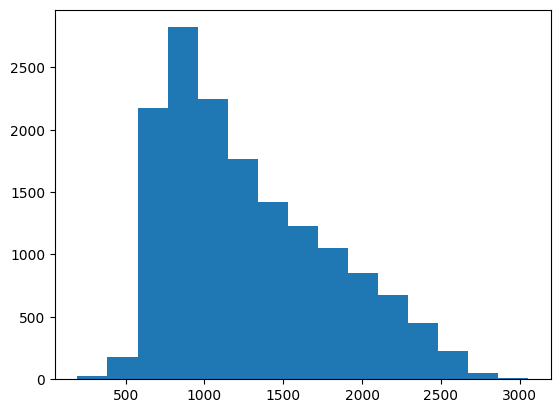

In [ ]:
plt.hist(text_lengths_in_words, bins = 15)


In [ ]:
from statistics import mean
print(mean(text_lengths_in_chars))
print(mean(text_lengths_in_words))

10243.875519493371
1285.8327066429183


In [ ]:
train_pairs = []
for example in billsum_train:
  orig = example['text']
  target = example['summary']
  title = example['title']
  train_pairs.append({'orig': orig, 'target': target, 'title': title})

valid_pairs = []
for example in billsum_valid:
  orig = example['text']
  target = example['summary']
  title = example['title']
  valid_pairs.append({'orig': orig, 'target': target, 'title': title})

test_pairs = []
for example in billsum_test:
  orig = example['text']
  target = example['summary']
  title = example['title']
  test_pairs.append({'orig': orig, 'target': target, 'title': title})

#from pprint import pprint
#pprint(train_pairs[:2])
#train_pairs[0].keys()

In [ ]:
# Save splits to separate csv files, to load only part at a time later
train_file = "drive/MyDrive/266project/billsum_train.csv"
valid_file = "drive/MyDrive/266project/billsum_valid.csv"
test_file = "drive/MyDrive/266project/billsum_test.csv"
pd.DataFrame(train_pairs).to_csv(train_file)
pd.DataFrame(valid_pairs).to_csv(valid_file)
pd.DataFrame(test_pairs).to_csv(test_file, escapechar='\\')

In [ ]:
# test that we can access data
train_data = pd.read_csv("drive/MyDrive/266project/billsum_train.csv")
valid_data = pd.read_csv("drive/MyDrive/266project/billsum_valid.csv")
test_data = pd.read_csv("drive/MyDrive/266project/billsum_test.csv")
train_data.drop(columns=['Unnamed: 0'], inplace=True)
valid_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

train_data.head()

,orig,target,title
0,SECTION 1. SHORT TITLE.\n\n This Act may be...,Employee Participation Incentive Act of 1998 -...,Employee Participation Incentive Act of 1998
1,SECTION 1. SHORT TITLE.\n\n This Act may be...,Pay Back America Act of 2004 - Amends the Inte...,To amend the Internal Revenue Code of 1986 to ...
2,SECTION 1. SHORT TITLE.\n\n This Act may be...,Local Job Opportunities and Business Success A...,To amend the Workforce Investment Act of 1998 ...
3,SECTION 1. WAGE DETERMINATION.\n\n (a) Chan...,Amends the Immigration and Nationality Act to ...,To amend the Immigration and Nationality Act t...
4,SECTION 1. SHORT TITLE.\n\n This Act may b...,Housing Affordability Assurance Act - Requires...,To require a housing impact analysis of any ne...
